## Import Packages

In [1]:
from data import shortestpath, dataset
from model import shortestPathModel
from loss import SPOPlusLoss
from evalm import SPOEval

In [2]:
import time
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader

## Build Model 

In [3]:
# model for shortest path
grid = (5,5)
sp_model = shortestPathModel(grid)

Academic license - for non-commercial use only - expires 2021-04-13
Using license file C:\Users\Apocrypse\gurobi.lic


## Training

In [4]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, (grid[0] - 1) * grid[1] + (grid[1] - 1) * grid[0])
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [5]:
def train(dataloader, opt_model, num_epochs, learning_rate, l1_lambda):
    """
    train model with SPO+ Loss
    args:
      dataloader: dataloader from optDataSet
      model: optModel
      num_epochs: number of epochs
      l2_lambda: l2 regularization parameter
    """
    print('Training...')
    # init model
    lr = LinearRegression()
    # cuda
    if torch.cuda.is_available():
        lr = lr.cuda()
    # training mode
    lr.train()
    # set optimizer
    optimizer = torch.optim.Adam(lr.parameters(), lr=learning_rate)
    # set SPO+ Loss as criterion
    criterion = SPOPlusLoss()
    # train
    time.sleep(1)
    for epoch in tqdm(range(num_epochs)):
        # load data
        for i, data in enumerate(dataloader):
            x, c, w, z = data
            # cuda
            if torch.cuda.is_available():
                x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
            # forward pass
            cp = lr(x)
            loss = criterion.apply(opt_model, cp, c, w, z).mean()
            # l1 reg
            l1_reg = torch.abs(cp - c).sum(dim=1).mean()
            loss += l1_lambda * l1_reg
            # learning rate decay
            cur_lr = learning_rate * 0.6 ** math.floor((epoch / num_epochs) * 10)
            for param_group in optimizer.param_groups:
                param_group['lr'] = cur_lr
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return lr

## Experiments

### Training Set Size = 100, Noise Half−width = 0

In [6]:
# set up
n = 100 # number of data
p = 5 # size of feature
e = 0 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [7]:
# init DataFrame
df1 = pd.DataFrame(columns = degs)

In [8]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-3 * (3 ** deg + 1)
        num_epochs = 500 * deg
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = SPOEval(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df1 = df1.append(row, ignore_index = True)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 181.42it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 205.60it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [03:48<00:00,  2.19it/s]


Normalized SPO Loss: 0.40%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 200.00it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 225.61it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [08:05<00:00,  2.06it/s]


Normalized SPO Loss: 0.17%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 317.55it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 218.37it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [14:51<00:00,  2.24it/s]


Normalized SPO Loss: 1.43%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 284.83it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 265.24it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 3000/3000 [19:40<00:00,  2.54it/s]


Normalized SPO Loss: 3.71%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 220.44it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.46it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [03:04<00:00,  2.70it/s]


Normalized SPO Loss: 0.30%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 269.22it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.95it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [06:07<00:00,  2.72it/s]


Normalized SPO Loss: 0.19%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 330.15it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 295.53it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [12:03<00:00,  2.76it/s]


Normalized SPO Loss: 1.38%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 304.77it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.01it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 3000/3000 [18:37<00:00,  2.68it/s]


Normalized SPO Loss: 5.06%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 221.82it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 257.27it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:57<00:00,  2.82it/s]


Normalized SPO Loss: 0.26%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 323.44it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 292.75it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:56<00:00,  2.80it/s]


Normalized SPO Loss: 0.20%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 302.31it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.60it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [11:47<00:00,  2.83it/s]


Normalized SPO Loss: 1.85%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 374.13it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.91it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 3000/3000 [17:34<00:00,  2.85it/s]


Normalized SPO Loss: 5.74%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 272.49it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.37it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:51<00:00,  2.91it/s]


Normalized SPO Loss: 0.33%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 322.40it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.20it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:52<00:00,  2.84it/s]


Normalized SPO Loss: 0.18%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 321.37it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 314.22it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [11:39<00:00,  2.86it/s]


Normalized SPO Loss: 2.16%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 285.66it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.66it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 3000/3000 [17:23<00:00,  2.87it/s]


Normalized SPO Loss: 6.95%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 169.09it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.37it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:59<00:00,  2.79it/s]


Normalized SPO Loss: 0.30%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 358.10it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.88it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:45<00:00,  2.89it/s]


Normalized SPO Loss: 0.26%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 261.79it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 200.49it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [11:44<00:00,  2.84it/s]


Normalized SPO Loss: 1.35%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 205.89it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.36it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 3000/3000 [18:09<00:00,  2.75it/s]


Normalized SPO Loss: 5.13%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 259.29it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 298.28it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:59<00:00,  2.79it/s]


Normalized SPO Loss: 0.33%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 246.08it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 268.09it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:57<00:00,  2.80it/s]


Normalized SPO Loss: 0.21%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 284.99it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.59it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [12:04<00:00,  2.76it/s]


Normalized SPO Loss: 1.95%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 207.59it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.12it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 3000/3000 [18:12<00:00,  2.74it/s]


Normalized SPO Loss: 6.52%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 286.20it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.46it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [03:07<00:00,  2.67it/s]


Normalized SPO Loss: 0.53%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 242.50it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.03it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:58<00:00,  2.79it/s]


Normalized SPO Loss: 0.15%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 290.62it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.30it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [12:09<00:00,  2.74it/s]


Normalized SPO Loss: 1.37%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 243.44it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.06it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 3000/3000 [18:06<00:00,  2.76it/s]


Normalized SPO Loss: 4.36%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 323.38it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 236.95it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [03:14<00:00,  2.57it/s]


Normalized SPO Loss: 0.41%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 311.63it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.52it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [07:06<00:00,  2.35it/s]


Normalized SPO Loss: 0.16%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 269.49it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 248.08it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [12:41<00:00,  2.62it/s]


Normalized SPO Loss: 1.48%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 179.74it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 176.93it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 3000/3000 [19:18<00:00,  2.59it/s]


Normalized SPO Loss: 5.59%



Text(0, 0.5, 'Normalized SPO Loss')

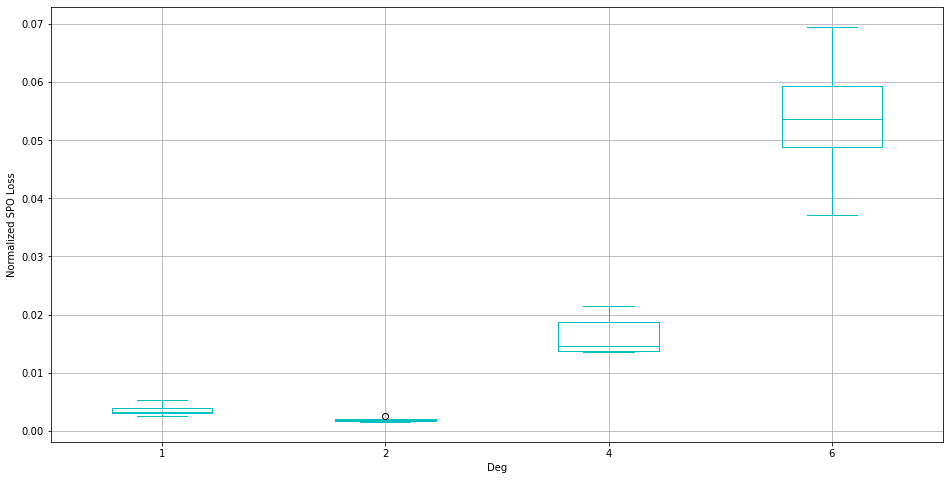

In [9]:
# draw boxplot
bplot = df1.boxplot(figsize=(16,8), color='c')
bplot.set_xlabel('Deg')
bplot.set_ylabel('Normalized SPO Loss')

### Training Set Size = 100, Noise Half−width = 0.5

In [10]:
# set
n = 100 # number of data
p = 5 # size of feature
e = 0.5 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [11]:
# init DataFrame
df2 = pd.DataFrame(columns = degs)

In [12]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-3 * (3 ** deg + 1)
        num_epochs = 500 * deg
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = SPOEval(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df2 = df2.append(row, ignore_index = True)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 299.31it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.49it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [03:39<00:00,  2.28it/s]


Normalized SPO Loss: 19.84%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 216.32it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 246.81it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [06:39<00:00,  2.51it/s]


Normalized SPO Loss: 12.00%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 319.32it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.87it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [13:53<00:00,  2.40it/s]


Normalized SPO Loss: 9.26%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 227.61it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 283.66it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 3000/3000 [19:25<00:00,  2.57it/s]


Normalized SPO Loss: 11.92%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 210.56it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 272.12it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [03:11<00:00,  2.62it/s]


Normalized SPO Loss: 17.51%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 331.39it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.89it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [06:35<00:00,  2.53it/s]


Normalized SPO Loss: 10.43%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 340.01it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.79it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [12:58<00:00,  2.57it/s]


Normalized SPO Loss: 7.33%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 331.17it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 245.90it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 3000/3000 [18:32<00:00,  2.70it/s]


Normalized SPO Loss: 9.44%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 285.66it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 325.97it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:58<00:00,  2.81it/s]


Normalized SPO Loss: 19.26%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 356.82it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.47it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [06:04<00:00,  2.74it/s]


Normalized SPO Loss: 12.68%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 365.98it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 290.97it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [11:46<00:00,  2.83it/s]


Normalized SPO Loss: 10.57%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 330.92it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.41it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 3000/3000 [17:59<00:00,  2.78it/s]


Normalized SPO Loss: 13.10%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 374.08it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.79it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [03:00<00:00,  2.78it/s]


Normalized SPO Loss: 19.78%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 308.51it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.30it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [06:05<00:00,  2.74it/s]


Normalized SPO Loss: 12.91%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 412.62it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 314.51it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [11:56<00:00,  2.79it/s]


Normalized SPO Loss: 10.99%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 302.92it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 244.14it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 3000/3000 [18:06<00:00,  2.76it/s]


Normalized SPO Loss: 16.27%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 292.33it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.66it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:59<00:00,  2.79it/s]


Normalized SPO Loss: 19.81%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 379.80it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 320.04it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:59<00:00,  2.78it/s]


Normalized SPO Loss: 12.56%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 261.81it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.10it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [12:00<00:00,  2.78it/s]


Normalized SPO Loss: 9.51%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 343.38it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.18it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 3000/3000 [18:29<00:00,  2.70it/s]


Normalized SPO Loss: 10.87%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 355.56it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.45it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [03:05<00:00,  2.69it/s]


Normalized SPO Loss: 19.17%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 281.65it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.79it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [06:04<00:00,  2.74it/s]


Normalized SPO Loss: 11.47%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 329.83it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 320.34it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [11:58<00:00,  2.78it/s]


Normalized SPO Loss: 8.70%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 299.31it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 263.38it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 3000/3000 [19:58<00:00,  2.50it/s]


Normalized SPO Loss: 11.41%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 263.47it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 254.56it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [03:30<00:00,  2.38it/s]


Normalized SPO Loss: 18.49%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 223.31it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 276.70it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [06:50<00:00,  2.44it/s]


Normalized SPO Loss: 12.33%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 202.50it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 272.26it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [13:55<00:00,  2.39it/s]


Normalized SPO Loss: 9.46%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 301.81it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 276.64it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 3000/3000 [20:24<00:00,  2.45it/s]


Normalized SPO Loss: 9.33%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 324.49it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 274.71it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [03:09<00:00,  2.63it/s]


Normalized SPO Loss: 18.40%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 274.70it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.65it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [06:13<00:00,  2.68it/s]


Normalized SPO Loss: 11.34%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 230.50it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 302.01it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [12:57<00:00,  2.57it/s]


Normalized SPO Loss: 8.77%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 355.46it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.62it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 3000/3000 [19:06<00:00,  2.62it/s]


Normalized SPO Loss: 11.42%



Text(0, 0.5, 'Normalized SPO Loss')

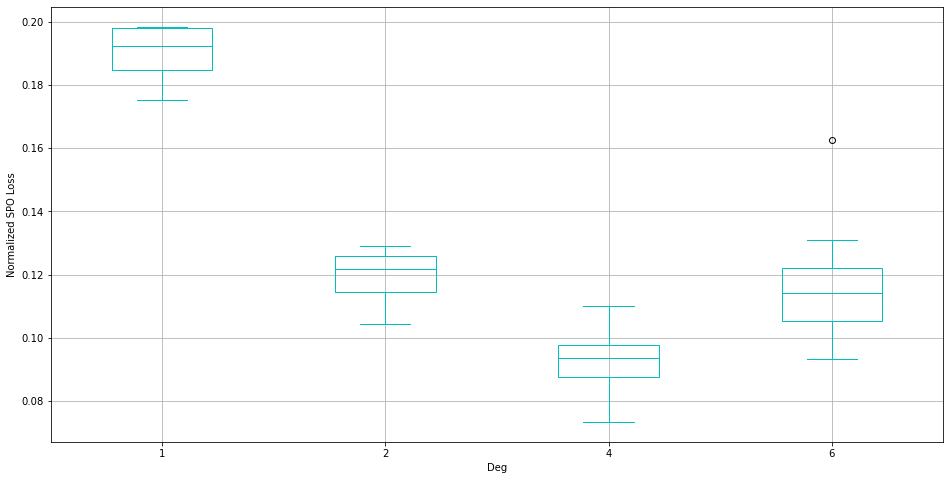

In [13]:
# draw boxplot
bplot = df2.boxplot(figsize=(16,8), color='c')
bplot.set_xlabel('Deg')
bplot.set_ylabel('Normalized SPO Loss')

## Training Set Size = 1000, Noise Half−width = 0 

In [14]:
# set
n = 1000 # number of data
p = 5 # size of feature
e = 0 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [15]:
# init DataFrame
df3 = pd.DataFrame(columns = degs)

In [16]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-3 * (3 ** deg + 1)
        num_epochs = 50 * deg
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = SPOEval(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df3 = df3.append(row, ignore_index = True)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 268.03it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 246.83it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 50/50 [03:32<00:00,  4.26s/it]


Normalized SPO Loss: 0.10%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.72it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.81it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [06:28<00:00,  3.88s/it]


Normalized SPO Loss: 0.07%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 246.04it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 233.41it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [12:46<00:00,  3.83s/it]


Normalized SPO Loss: 0.83%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 283.29it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 240.98it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [19:12<00:00,  3.84s/it]


Normalized SPO Loss: 3.49%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 274.60it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 274.30it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 50/50 [03:09<00:00,  3.80s/it]


Normalized SPO Loss: 0.13%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 292.26it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 228.41it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [06:22<00:00,  3.83s/it]


Normalized SPO Loss: 0.05%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 274.00it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 279.45it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [12:44<00:00,  3.82s/it]


Normalized SPO Loss: 0.75%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 311.49it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.29it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [17:57<00:00,  3.59s/it]


Normalized SPO Loss: 3.31%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.44it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.85it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 50/50 [03:00<00:00,  3.61s/it]


Normalized SPO Loss: 0.13%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.65it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.30it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:56<00:00,  3.57s/it]


Normalized SPO Loss: 0.12%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.74it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.12it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [12:59<00:00,  3.90s/it]


Normalized SPO Loss: 1.28%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.75it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 325.44it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [17:52<00:00,  3.58s/it]


Normalized SPO Loss: 4.70%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.18it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 253.84it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 50/50 [02:58<00:00,  3.58s/it]


Normalized SPO Loss: 0.23%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 308.80it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.10it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [06:06<00:00,  3.67s/it]


Normalized SPO Loss: 0.08%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 302.28it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 298.95it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [12:00<00:00,  3.60s/it]


Normalized SPO Loss: 1.24%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.47it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 311.21it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [18:08<00:00,  3.63s/it]


Normalized SPO Loss: 4.64%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 265.26it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 252.82it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 50/50 [03:01<00:00,  3.63s/it]


Normalized SPO Loss: 0.13%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 295.43it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 295.25it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:58<00:00,  3.59s/it]


Normalized SPO Loss: 0.08%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 308.75it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.27it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [12:04<00:00,  3.62s/it]


Normalized SPO Loss: 0.97%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.83it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 247.27it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [18:12<00:00,  3.64s/it]


Normalized SPO Loss: 3.63%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.66it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.66it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 50/50 [02:58<00:00,  3.56s/it]


Normalized SPO Loss: 0.15%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.23it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.18it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:57<00:00,  3.58s/it]


Normalized SPO Loss: 0.11%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 302.46it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.71it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [12:00<00:00,  3.60s/it]


Normalized SPO Loss: 1.20%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 263.45it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 244.38it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [18:20<00:00,  3.67s/it]


Normalized SPO Loss: 4.30%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 302.83it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.99it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 50/50 [02:56<00:00,  3.53s/it]


Normalized SPO Loss: 0.19%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.25it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.51it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:58<00:00,  3.59s/it]


Normalized SPO Loss: 0.05%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 271.14it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 250.29it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [12:17<00:00,  3.69s/it]


Normalized SPO Loss: 0.67%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.43it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.47it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [17:42<00:00,  3.54s/it]


Normalized SPO Loss: 2.68%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.76it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.29it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 50/50 [02:59<00:00,  3.59s/it]


Normalized SPO Loss: 0.12%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.24it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 302.01it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:58<00:00,  3.59s/it]


Normalized SPO Loss: 0.07%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 298.41it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.77it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [11:58<00:00,  3.59s/it]


Normalized SPO Loss: 0.97%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 254.23it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 263.03it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [17:46<00:00,  3.56s/it]


Normalized SPO Loss: 3.94%



Text(0, 0.5, 'Normalized SPO Loss')

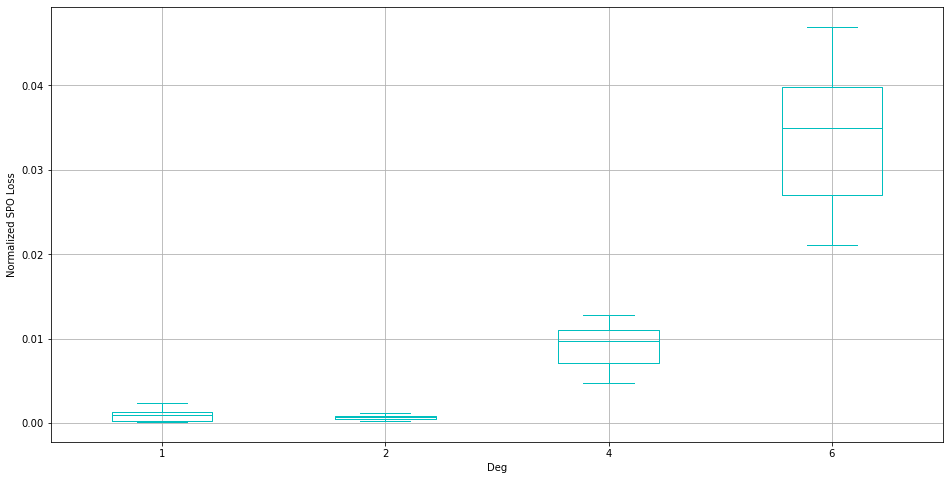

In [17]:
# draw boxplot
bplot = df3.boxplot(figsize=(16,8), color='c')
bplot.set_xlabel('Deg')
bplot.set_ylabel('Normalized SPO Loss')

## Training Set Size = 1000, Noise Half−width = 0.5 

In [18]:
# set
n = 1000 # number of data
p = 5 # size of feature
e = 0.5 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [19]:
# init DataFrame
df4 = pd.DataFrame(columns = degs)

In [20]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-3 * (3 ** deg + 1)
        num_epochs = 50 * deg
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = SPOEval(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df4 = df4.append(row, ignore_index = True)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 236.40it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 286.91it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 50/50 [03:03<00:00,  3.67s/it]


Normalized SPO Loss: 16.84%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.92it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 295.51it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [07:12<00:00,  4.33s/it]


Normalized SPO Loss: 10.51%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 256.11it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 253.41it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [15:40<00:00,  4.70s/it]


Normalized SPO Loss: 7.49%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 250.24it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 258.79it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [20:55<00:00,  4.19s/it]


Normalized SPO Loss: 9.52%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 232.77it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 225.98it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 50/50 [03:47<00:00,  4.54s/it]


Normalized SPO Loss: 15.82%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 248.92it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 264.18it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [07:24<00:00,  4.44s/it]


Normalized SPO Loss: 9.22%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 254.49it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 251.72it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [14:01<00:00,  4.21s/it]


Normalized SPO Loss: 7.00%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 233.44it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 276.00it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [19:18<00:00,  3.86s/it]


Normalized SPO Loss: 7.83%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.60it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 292.94it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 50/50 [03:12<00:00,  3.84s/it]


Normalized SPO Loss: 17.97%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 276.24it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 290.22it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [06:30<00:00,  3.90s/it]


Normalized SPO Loss: 11.46%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 204.09it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.19it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [13:43<00:00,  4.12s/it]


Normalized SPO Loss: 9.07%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 237.81it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 210.09it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [20:04<00:00,  4.01s/it]


Normalized SPO Loss: 11.08%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.36it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 255.56it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 50/50 [03:09<00:00,  3.79s/it]


Normalized SPO Loss: 17.08%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 282.58it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 291.42it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [06:19<00:00,  3.79s/it]


Normalized SPO Loss: 11.31%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.02it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 209.42it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [13:09<00:00,  3.95s/it]


Normalized SPO Loss: 9.08%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.91it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 291.45it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [18:59<00:00,  3.80s/it]


Normalized SPO Loss: 10.77%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 280.17it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.41it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 50/50 [03:05<00:00,  3.71s/it]


Normalized SPO Loss: 18.28%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.03it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 287.00it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [06:31<00:00,  3.92s/it]


Normalized SPO Loss: 12.23%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 240.48it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 236.14it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [12:18<00:00,  3.69s/it]


Normalized SPO Loss: 9.52%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.53it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.02it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [18:08<00:00,  3.63s/it]


Normalized SPO Loss: 11.42%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.55it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.95it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 50/50 [03:07<00:00,  3.75s/it]


Normalized SPO Loss: 17.55%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.26it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 288.62it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [06:03<00:00,  3.64s/it]


Normalized SPO Loss: 11.13%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 295.34it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 295.16it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [12:13<00:00,  3.67s/it]


Normalized SPO Loss: 8.84%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 288.29it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.41it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [18:23<00:00,  3.68s/it]


Normalized SPO Loss: 12.06%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 274.10it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.97it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 50/50 [02:58<00:00,  3.58s/it]


Normalized SPO Loss: 18.04%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.46it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.53it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [06:05<00:00,  3.66s/it]


Normalized SPO Loss: 10.88%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.80it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.00it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [12:10<00:00,  3.65s/it]


Normalized SPO Loss: 8.07%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 255.20it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 288.29it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [18:08<00:00,  3.63s/it]


Normalized SPO Loss: 9.03%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.21it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 290.21it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 50/50 [03:05<00:00,  3.72s/it]


Normalized SPO Loss: 15.72%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 258.49it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 248.31it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [06:06<00:00,  3.67s/it]


Normalized SPO Loss: 9.96%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 277.83it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.58it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [12:05<00:00,  3.63s/it]


Normalized SPO Loss: 7.35%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 295.51it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.28it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [18:21<00:00,  3.67s/it]


Normalized SPO Loss: 9.17%



Text(0, 0.5, 'Normalized SPO Loss')

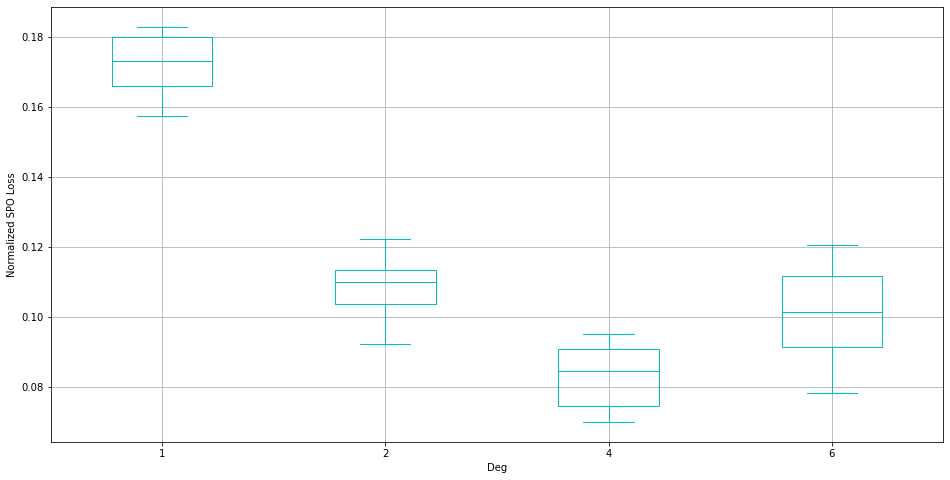

In [21]:
# draw boxplot
bplot = df4.boxplot(figsize=(16,8), color='c')
bplot.set_xlabel('Deg')
bplot.set_ylabel('Normalized SPO Loss')

## Save File 

In [22]:
df1.to_csv('./res/spoplus_n100.csv', index=False)
df2.to_csv('./res/spoplus_n100_noise.csv', index=False)
df3.to_csv('./res/spoplus_n1000.csv', index=False)
df4.to_csv('./res/spoplus_n1000_noise.csv', index=False)